# Notes on CNNs

From Chapter 13 of Hands-On Machine Learning textbook by Aurelien Geron. 

NOTE: Follow up with these blog posts for further reading. This chapter is missing explanation on a few key details:

- http://cs231n.github.io/convolutional-networks/
- https://ujjwalkarn.me/2016/08/11/intuitive-explanation-convnets/
- https://adeshpande3.github.io/adeshpande3.github.io/A-Beginner's-Guide-To-Understanding-Convolutional-Neural-Networks-Part-2/

## Setup:

In [27]:
# To support both python 2 and python 3
from __future__ import division, print_function, unicode_literals

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
def reset_graph(seed=42):
    tf.reset_default_graph()
    tf.set_random_seed(seed)
    np.random.seed(seed)

# To plot pretty figures
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 1

# A couple utility functions to plot grayscale and RGB images:
def plot_image(image,title=None):
    plt.imshow(image, cmap="gray", interpolation="nearest")
    plt.axis("on")
    if title:
        plt.title(title)
    plt.show()

def plot_color_image(image):
    plt.imshow(image.astype(np.uint8),interpolation="nearest")
    plt.axis("on")
    plt.title(title)

# And of course we will need TensorFlow:
import tensorflow as tf

Convolutional neural networks (CNNs) emerged from the study of the brain's visual cortex, and they have been used in image recognition since the 1980s. In the last few years, thanks to the increase in computational power, the amount of available training data, and the tricks presented in Chapter 11 for training deep nets, CNNs have managed to achieve superhuman performance on some complex visual tasks. 

They power image search services, self-driving cars, automatic video classification systems, and more. **Moreover, CNNs are not restricted to visual perception: they are also successful at other tasks, such as voice recognition or natural language processing (NLP);** however, we will focus on
visual applications for now.

In this chapter we will present where CNNs came from, what their building blocks look like, and how to implement them using TensorFlow. Then we will present some of the best CNN architectures.

# Architecture of the Visual Cortex

**Hubel and Torsten research on the visual coretex from 1959:** they showed that many neurons in the visual cortex have a small local receptive field, meaning they **react only to visual stimuli located in a limited region of the visual field (see graph below, in which
the local receptive fields of five neurons are represented by dashed circles).** 

The receptive fields of different neurons may overlap, and together they tile the whole visual field. **Moreover, the authors showed that some neurons react only to images of horizontal lines, while others react only to lines with different orientations (two neurons may have the same receptive field but react to different line orientations).** They also noticed that some neurons have larger receptive fields, and they react to more complex patterns that are combinations of the lower-level patterns. These observations led to the idea that the higher-level neurons are based on the outputs of neighboring lower-level neurons (in the graph below, notice that each neuron is connected only to a few neurons from the previous layer). This powerful architecture is able to detect all sorts of complex patterns in any area of the visual field.

![](pictures\homl_ch13_viscort.jpg)

These studies of the visual cortex inspired the neocognitron, introduced in 1980, which gradually evolved into what we now call convolutional neural networks. An important milestone was a 1998 paper by Yann LeCun, Léon Bottou, Yoshua Bengio, and Patrick Haffner, which **introduced the
famous LeNet-5 architecture, widely used to recognize handwritten check numbers.** This architecture has some building blocks that you already know, such as fully connected layers and sigmoid activation functions, but it also introduces two new building blocks: 
- convolutional layers and
- pooling layers. 

Let’s look at them now.

### SIDENOTE:
Why not simply use a regular deep neural network with fully connected layers for image recognition tasks? **Unfortunately, although this works fine for small images (e.g., MNIST), it breaks down for larger images because of the huge number of parameters it requires.** For example, a 100 × 100 image has 10,000 pixels, and if the first layer has just 1,000 neurons (which already severely restricts the amount of information transmitted to the next layer), this means a total of 10 million
connections. And that’s just the first layer. CNNs solve this problem using partially connected layers.

# Convolutional Layer
Most important building block of a CNN is the convolutional layer:
- neurons in the first convolutional layer are not connected to every single pixel in the input image (like they were in previous chapters), but **only to pixels in their receptive fields.** 
- In turn, each neuron in the SECOND convultional layer is connected ONLY to neurons located within a small rectangle in the first layer.

This architecture allows the network to concentrate on low-level features in the first hidden layer, THEN assemble them into higher level features in the next hidden layer, and so on.

![](pictures/homl_ch13_convlayers.jpg)

### SIDENOTE:
Until now, all multilater neural networks we have seen were composed of a long line of neurons... and we often had to flatten images to 1D before feeding them into the neural netowkr. WELL NOTE WITH CONV NETWORKS! Now each layer is represented in 2D, which make it easier to match neurons with their corresponding inputs. 

A neuron located in **row i of column j** of a given layer is connected to the outputs of the neurons in the previous layer located in **rows i to i + fh – 1, columns j to j +fw -1,** where fh and fw are the height and width of the receptive field.

In order for a layer to have the same height and width as the previous layer, it is common to add zeros around the inputs, as shown in the diagram. **This is called zero padding**.

![](pictures/homl_ch13_rowicolj.jpg)

It is also possible to connect a larger input layer to a much smaller layer by **spacing out the receptive fields**. The distance between two consecutive receptive fields is called the **STRIDE**. In the diagram, a 5 X 7 input layer (plus zero padding) is connected to a 3 X 4layer, using a 3 x 3 receptive field and a stride of 2 **(in this example the stride is the same in both direcitons, but it does NOT have to be so).** A neuonr located in row i, column j, in the upper layer, is connected to the outputs of the neyrons in the previous layer located in **rows (i x sh) to (i X sh + fh - 1),** and  columns j × sw +
fw – 1, where sh and sw are the vertical and horizontal strides.


**REDUCING DIMENSIONALITY USING A STRIDE:**
![](pictures/homl_ch13_rowicolj2.jpg)


## Filters

**A neuron's weight can be represented as a small image the size of the receptive field.** For example, the diagram below shows two possible sets of weights, called filters (or convolutional kernels). 
- FEATURE MAP 1: The first one is represented as a black square with a vertical white line in the middle: Its a 7 x 7 matrix full of 0s except for the central column, which is full of 1s
    - Neurons using these weights will ignore everything in their receptive field except for the central vertical line (since all inputs get multiplied by 0, except for the ones located in the central vertical line). 
- FEATURE MAP 2: The second filter is a black square with a horizontal white line in the middle:
    - Once again, neurons using these weights will ignore everything in their receptive field except for the central horizontal lin. 
    
    

In [28]:
from PIL import Image
from sklearn.datasets import load_sample_image
china = load_sample_image("china.jpg")
flower = load_sample_image("flower.jpg")

#create truncated image (for easy processing)
image = china[150:220, 130:250]
height, width, channels = image.shape

#take mean of 3 RBG values to get greyscale... neat!!!
image_grayscale = image.mean(axis=2).astype(np.float32)
images = image_grayscale.reshape(1, height, width, 1)

In [29]:
# 5 rows of pixels, in the 5th column of pixels
print(china[0:5,5],'\n')
print(image[0:5,5],'\n')
#note there will be only one column here because there is only ONE pixel color value
print(image_grayscale[0:5,5])

[[174 201 231]
 [174 201 231]
 [174 201 231]
 [174 201 231]
 [175 202 231]] 

[[60 44 44]
 [51 39 39]
 [47 33 32]
 [65 49 49]
 [59 39 40]] 

[ 49.33333206  43.          37.33333206  54.33333206  46.        ]


In [30]:
china

array([[[174, 201, 231],
        [174, 201, 231],
        [174, 201, 231],
        ..., 
        [250, 251, 255],
        [250, 251, 255],
        [250, 251, 255]],

       [[172, 199, 229],
        [173, 200, 230],
        [173, 200, 230],
        ..., 
        [251, 252, 255],
        [251, 252, 255],
        [251, 252, 255]],

       [[174, 201, 231],
        [174, 201, 231],
        [174, 201, 231],
        ..., 
        [252, 253, 255],
        [252, 253, 255],
        [252, 253, 255]],

       ..., 
       [[ 88,  80,   7],
        [147, 138,  69],
        [122, 116,  38],
        ..., 
        [ 39,  42,  33],
        [  8,  14,   2],
        [  6,  12,   0]],

       [[122, 112,  41],
        [129, 120,  53],
        [118, 112,  36],
        ..., 
        [  9,  12,   3],
        [  9,  15,   3],
        [ 16,  24,   9]],

       [[116, 103,  35],
        [104,  93,  31],
        [108, 102,  28],
        ..., 
        [ 43,  49,  39],
        [ 13,  21,   6],
        [ 15,  24,

Original Image Shape:
 (427, 640, 3)
Truncated Image Shape:
 (70, 120, 3)
Truncated Greyscale Image Shape:
 (70, 120)


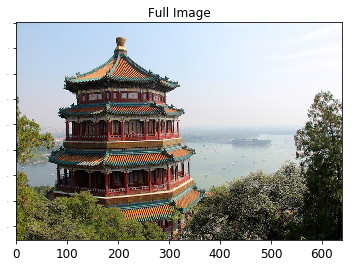

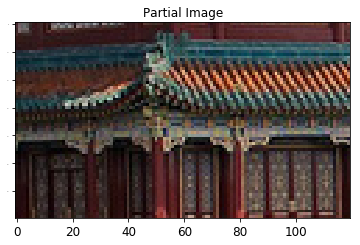

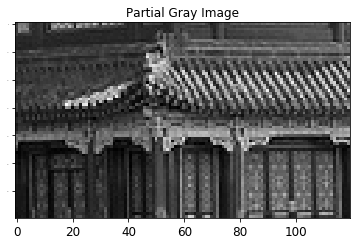

In [31]:
# show all images you created
print('Original Image Shape:\n', china.shape)
print('Truncated Image Shape:\n', image.shape)
print('Truncated Greyscale Image Shape:\n', image_grayscale.shape)

plot_image(china,'Full Image')
plot_image(image,'Partial Image')
plot_image(image_grayscale,'Partial Gray Image')

Vertical Filter:
 [[ 0.  0.  0.  1.  0.  0.  0.]
 [ 0.  0.  0.  1.  0.  0.  0.]
 [ 0.  0.  0.  1.  0.  0.  0.]
 [ 0.  0.  0.  1.  0.  0.  0.]
 [ 0.  0.  0.  1.  0.  0.  0.]
 [ 0.  0.  0.  1.  0.  0.  0.]
 [ 0.  0.  0.  1.  0.  0.  0.]]
Horizontal Filter:
 [[ 0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.]
 [ 1.  1.  1.  1.  1.  1.  1.]
 [ 0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.]]


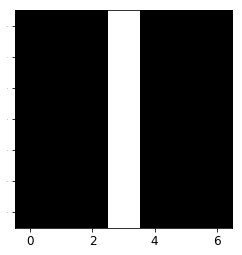

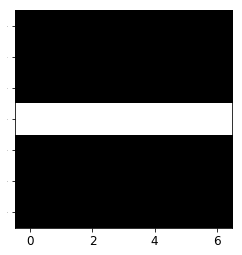

In [32]:
# create transofrmations
fmap = np.zeros(shape=(7, 7, 1, 2), dtype=np.float32)
fmap[:, 3, 0, 0] = 1
fmap[3, :, 0, 1] = 1

print("Vertical Filter:\n",fmap[:, :, 0, 0] )
print("Horizontal Filter:\n",fmap[:, :, 0, 1] )

plot_image(fmap[:, :, 0, 0])
plot_image(fmap[:, :, 0, 1])

#### APPLY FILTERS

In [34]:
print("Height: ", height)
print("Weight: ", width)
print("FEATURE MAP Shape: ", fmap.shape)

Height:  70
Weight:  120
FEATURE MAP Shape:  (7, 7, 1, 2)


In [37]:
reset_graph()

#set up graph
#NOTE: the firest 'None' represents the fact that you can put an array of MULTIPLE IMAGES into the placeholder
X = tf.placeholder(tf.float32, shape=(None, height, width, 1))
feature_maps = tf.constant(fmap)
convolution = tf.nn.conv2d(X, feature_maps, strides=[1,2,2,1], padding='SAME')

#run graph
with tf.Session() as sess:
    output = convolution.eval(feed_dict = {X: images})

(70, 120)
(35, 60)
(35, 60)


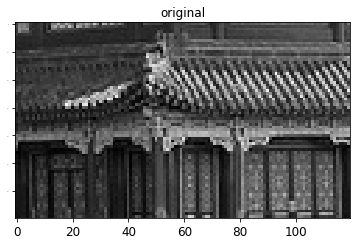

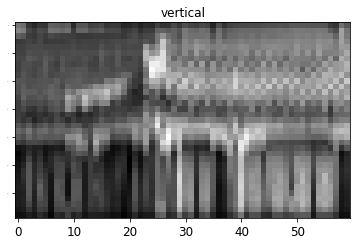

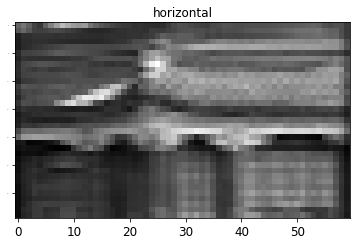

In [38]:
#plot shapes
print(images[0,:,:,0].shape)
print(output[0,:,:,0].shape)
print(output[0,:,:,1].shape)
#plot results
plot_image(images[0,:,:,0], 'original')
plot_image(output[0,:,:,0], 'vertical')
plot_image(output[0,:,:,1], 'horizontal')

Now if all neurons in a layer use the same vertical line filter (and the same bias term), and you feed the network the input image shwon above, the layer will output the 'vertical' image. 

**Notice that the vertical white lines get enhanced while the rest gets blurred. Similarly, the 'horizontal' image is what you get if all neurons use the horizontal line filter; notice that the horizontal
white lines get enhanced while the rest is blurred out.** 

### Thus, a layer full of neurons using the same filter gives you a feature map, which highlights the areas in an image that are most similar to the filter.

### During training, a CNN finds the most useful filters for its task, and it learns to combine them into more complex patterns (e.g., a cross is an area in an image where both the vertical filter and the horizontal filter are active).

## Stacking Multiple Feature Maps
Up to now, for simplicity, we have represented each convolutional layer as a thin 2D layer, but in reality **EACH CONVULTIONAL LAYER IS COMPOSED OF SEVEAL FEATURE MAPS OF EQUAL SIZES, so it is more accurately represented in 3D (see below).** 

Within one feature map, all neurons share the same parameters (weights and bias term), but different feature maps may have different parameters (duh, if you put in a different feature map, it will have different "weights", **however the size must be the same!!!**). 

A neuron’s receptive field is the same as described earlier, but it extends across all the previous layers’ feature maps (as seen below... **I guess this just means that it picks up data that it is connected to data from the previous conv layer**). 

### In short, a convolutional layer simultaneously applies multiple filters to its inputs, making it capable of detecting multiple features anywhere in its inputs.

![](pictures/homl_ch13_stackingfeatmaps.jpg)

### MC SIDENOTE: A neuron I guess refers to a specific pixel value?!?

### Specifically, a neuron located in row i, column j of the feature map k in a given convolutional layer l is connected to the outputs of the neurons in the previous layer l – 1, located in rows i × sw to i × sw + fw – 1 and columns j × sh to j × sh + fh – 1, across all feature maps (in layer l – 1).  

Note that all neurons located in the same row i and column j but in different feature maps are connected to the outputs of the exact same neurons in the previous layer.

*OK, this makes sense. You can determine what neurons (pixels) in the feature map are connected to (in the previous feature map or conv layer) based on the width, height and stride of the filters from the previous feature map*


Equation 13-1 summarizes the preceding explanations in one big mathematical equation: *it shows how to compute the output of a given neuron in a convolutional layer. It is a bit ugly due to all the
different indices, but all it does is calculate the weighted sum of all the inputs, plus the bias term*.

![](pictures/homl_ch13_stackingfeatmaps2.jpg)

## TensorFlow Implementation

In TF, each input image is typically represented as a 3D tensor of:
- shape [height, width, channels].

A mini-batch size is represented as a 4D tensor of:
- shape [mini-batch size, height, width, channels]

The weights of a convolutional layer are respesnted as a 4D tensor of:
- shape [fh, fw, fn, fn′], which are the height, width, number of filters, and number of input chanells, respectively.

The bias terms of a convolutional layer are simply represented as a 1D tensor of:
- shape [fn].

Let’s look at a simple example. The following code:
- loads two sample images, using Scikit-Learn’s load_sample_images() (which loads two color images, one of a Chinese temple, and the other of a flower). 
- Then it creates two 7 × 7 filters (one with a vertical white line in the middle, and the other with a horizontal white line), 
- and applies them to both images using a convolutional layer built using TensorFlow’s conv2d() function (with zero padding and a stride of 2). 
- Finally, it plots one of the resulting feature maps.

![](pictures/homl_ch13_convnetcode.jpg)

#### Most of this code is self-explanatory, but the *conv2d()* line deserves a bit of explanation:
- **X** is the input mini-batch (a 4D tensor, as explained earlier), where the 'None' is the number of images... 
- **filters** is the set of filters to apply (also a 4D tensor, as explained earlier). **NOTE THAT THE NUMBER OF FEATURE MAPS IS THE 4TH ELEMENT, WHERARAS IN 'X' THE NUMBER OF INPUT IMAGES IS THE FIRST ELEMENT**
- **strides** is a four-element 1D array, where **the two central elements are the vertical and horizontal strides (sh and sw).** The first and last elements must currently be equal to 1. They may one day be used to specify a batch stride (to skip some instances) and a channel stride (to skip some of the previous layer’s feature maps or channels).
- ** padding must be either "VALID" or "SAME":**
    - If set to **"VALID"**, the convolutional layer does not use zero padding, and may ignore some rows and columns at the bottom and right of the input image, depending on the stride, as shown below (for simplicity, only the horizontal dimension is shown here, but of course the same logic applies to the vertical dimension).
    - If set to **"SAME"**, the convolutional layer uses zero padding *if necessary*. In this case, the number of output neurons is equal to the number of input neurons divided by the stride, rounded up (in this example, ceil (13 / 5) = 3). Then zeros are added as evenly as possible around the inputs.
    
![](pictures/homl_ch13_padding.jpg)

Unfortunately, convolutional layers have quite a few hyperparameters. You must choose:
- the number of filters, 
- filter dimensions:
    - height
    - width
    - strides
    - and the padding type. 
 
As always, you can use crossvalidation to find the right hyperparameter values, **but this is very time-consuming.** We will discuss common CNN architectures later, to give you some idea of what hyperparameter values work best in practice.

### Now lets try that simple code example for realsss yo!

China and Flower shapes
(427, 640, 3)
(427, 640, 3)
Full Dataset shapes (TWO IMAGES):  (2, 427, 640, 3)

Filters shape (FOUR FILTERS):  (7, 7, 3, 4)


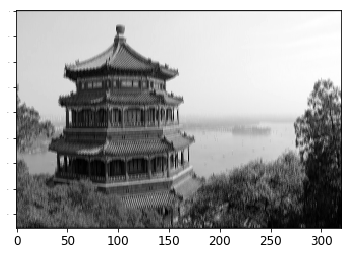

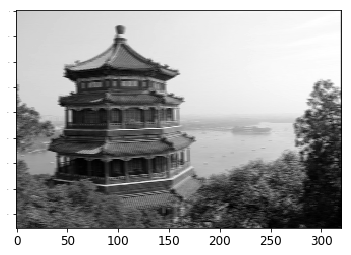

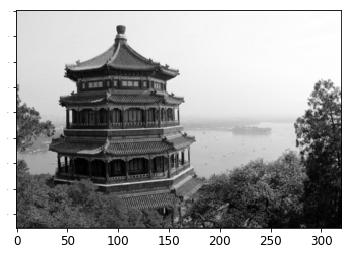

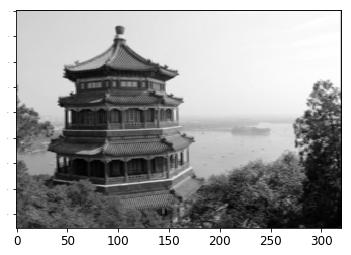

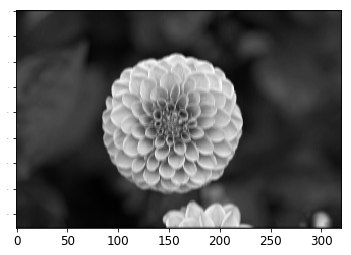

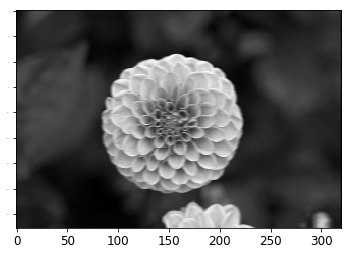

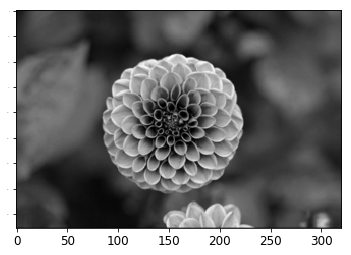

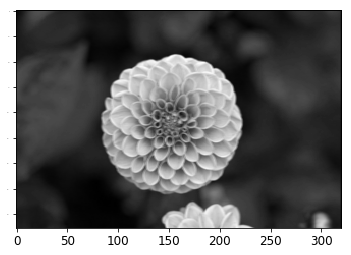

In [11]:
import numpy as np
from sklearn.datasets import load_sample_image

#load sample images
china = load_sample_image("china.jpg")
flower = load_sample_image("flower.jpg")

#both images should be the same size, with RGB channels
print('China and Flower shapes')
print(china.shape)
print(flower.shape)

#create the data set that will go into tf
#shape should be batch size, rows, columns, channels
#NOTE THAT THE NUMBER OF INPUTS IS THE FIRST ELEMENT
dataset = np.array([china, flower], dtype=np.float32)
print("Full Dataset shapes (TWO IMAGES): ", dataset.shape)

#extract data dimensions for TF
batch_size, height, width, channels = dataset.shape

#create 2 filters
#NOTE THAT THE NUMBER OF FEATURE MAPS IS THE LAST ELEMENT
filters = np.zeros(shape=(7, 7, channels, 4), dtype=np.float32)
filters[:, 3, :, 0] = 1 # vertical line
filters[3, :, :, 1] = 1  # horizontal line
filters[2:5,1:4,1:5,2] = 1 # random filter 1
filters[1:4,2:7,:,3] = 1 # random filter 2
print("\nFilters shape (FOUR FILTERS): ", filters.shape)

#Create a graph with X input plus a conv layer applying 2 filters
X = tf.placeholder(tf.float32, shape=(None, height, width, channels))
conv_layer = tf.nn.conv2d(X, filters, strides=[1,2,2,1], padding="SAME")

with tf.Session() as sess:
    output = sess.run(conv_layer, feed_dict={X: dataset})

#Plot 4 images (2 images x 2 feature maps)
for image_index in (0,1):
    for feature_map_index in [0,1,2,3]:
        plot_image(output[image_index,:,:,feature_map_index])

### Do something similar using tf.layers.conv2d instead!

It appears you don't have to actually define the filters here... maybe it just generates them randomly?!?! You will have to look into this...

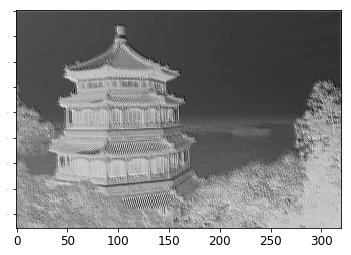

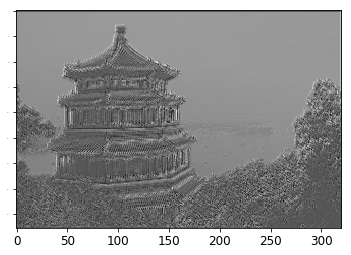

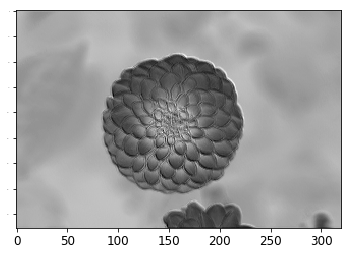

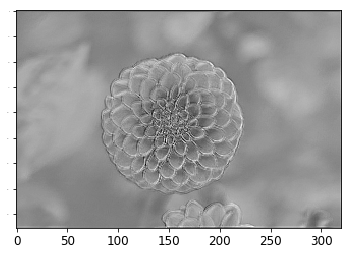

In [12]:
reset_graph()

X = tf.placeholder(shape=(None, height, width, channels), dtype=tf.float32)

#
conv_layer = tf.layers.conv2d(X, filters=3, 
                              kernel_size=7, 
                              strides=[2,2],
                              padding="SAME")

init = tf.global_variables_initializer()

with tf.Session() as sess:
    init.run()
    output = sess.run(conv_layer, feed_dict={X: dataset})
    
#Plot 4 images (2 images x 2 feature maps)
for image_index in (0,1):
    for feature_map_index in (0,1):
        plot_image(output[image_index,:,:,feature_map_index])

# VALID vs SAME padding!!!

In [13]:
reset_graph()

filter_primes = np.array([2., 3., 5., 7., 11., 13.], dtype=np.float32)
x = tf.constant(np.arange(1, 13+1, dtype=np.float32).reshape([1, 1, 13, 1]))
filters = tf.constant(filter_primes.reshape(1, 6, 1, 1))

valid_conv = tf.nn.conv2d(x, filters, strides=[1, 1, 5, 1], padding='VALID')
same_conv = tf.nn.conv2d(x, filters, strides=[1, 1, 5, 1], padding='SAME')

with tf.Session() as sess:
    print("VALID:\n", valid_conv.eval())
    print("SAME:\n", same_conv.eval())
    
print("VALID:")
print(np.array([1,2,3,4,5,6]).T.dot(filter_primes))
print(np.array([6,7,8,9,10,11]).T.dot(filter_primes))
print("SAME:")
print(np.array([0,1,2,3,4,5]).T.dot(filter_primes))
print(np.array([5,6,7,8,9,10]).T.dot(filter_primes))
print(np.array([10,11,12,13,0,0]).T.dot(filter_primes))


VALID:
 [[[[ 184.]
   [ 389.]]]]
SAME:
 [[[[ 143.]
   [ 348.]
   [ 204.]]]]
VALID:
184.0
389.0
SAME:
143.0
348.0
204.0


# Memory Requirements

Another problem with CNNs is that the convolutional layers require a huge amount of RAM, especially during training, **because the reverse pass of backpropagation requires all the intermediate values computed during the forward pass.**

For example, consider a convolutional layer with:
- 5 × 5 filters, 
- outputting 200 feature maps of size 150 × 100, 
- with stride 1 and SAME padding. 

### If the input is a 150 × 100 RGB image (three channels), then the number of parameters is (5 × 5 × 3 + 1) × 200 = 15,200 (the +1 corresponds to the bias terms), which is fairly small compared to a fully connected layer. 

### However, each of the 200 feature maps contains 150 × 100 neurons, and each of these neurons needs to compute a weighted sum of its 5 × 5 × 3 = 75 inputs: that’s a total of 225 million float multiplications. Not as bad as a fully connected layer, but still quite computationally intensive. 

Moreover, if the feature maps are represented using 32-bit floats, then the convolutional layer’s output will occupy 200 × 150 × 100 × 32 = 96 million bits (about 11.4 MB) of RAM.8 And that’s just for one instance! If a training batch contains 100
instances, then this layer will use up over 1 GB of RAM! During inference (i.e., when making a prediction for a new instance) the RAM occupied by one layer can be released as soon as the next layer has been computed, so you only need as much RAM as required by two consecutive layers. **But during training everything computed during the forward pass needs to be preserved for the reverse pass, so the amount of RAM needed is (at least) the total amount of RAM required by all layers.**

TIP: If training crashes because of an out-of-memory error, you can try reducing the mini-batch size. Alternatively, you can try reducing dimensionality using a stride, or removing a few layers. Or you can try using 16-bit floats instead of 32-bit floats. Or you could distribute the CNN across multiple devices.



## Pooling Layers

Once you understand how convolutional layers work, the pooling layers are quite easy to grasp. Their goal is to subsample (i.e., shrink) the input image in order to reduce the computational load, the memory usage, and the number of parameters **(thereby limiting the risk of overfitting). Reducing the input image size also makes the neural network tolerate a little bit of image shift (location invariance).**

####  Just like in convolutional layers, each neuron in a pooling layer is connected to the outputs of a limited number of neurons in the previous layer, located within a small rectangular receptive field. You must define its size, the stride, and the padding type, just like before. 

## However, a pooling neuron has no weights; all it does is aggregate the inputs using an aggregation function such as the max or mean. The figure below shows a max pooling layer, which is the most common type of pooling layer. 

In this example, we use a 2 × 2 pooling kernel, a stride of 2, and no padding. Note that only the max input value in each kernel makes it to the next layer. The other inputs are dropped.

![](pictures/homl_ch13_pooling2.jpg)

This is obviously **a very destructive kind of layer: even with a tiny 2 × 2 kernel and a stride of 2, the output will be two times smaller in both directions (so its area will be four times smaller), simply dropping 75% of the input values.**

### A pooling layer typically works on every input channel independently, so the output depth is the same as the input depth (which is why we have both color images above!!!!!)

You may alternatively pool over the depth dimension, as we will see next, in which case the image’s spatial dimensions (height and width) remain unchanged, but the number of channels is reduced. Implementing a max pooling layer in TensorFlow is quite easy. The following code creates a max pooling layer using a 2 × 2 kernel, stride 2, and no padding, then applies it to all the images in the dataset. 

A few notes on the following code:

- The **ksize argument** contains the kernel shape along all four dimensions of the input tensor: [batch size, height, width, channels].
    - ksize[0]: TensorFlow currently does not support pooling over multiple instances, **so the first element of ksize must be equal to 1.**
    - Moreover, TF does not support pooling over both the spatial dimensions (height and width) and the depth dimension, **so either ksize[1] and ksize[2] must both be equal to 1, or ksize[3] must be equal to 1.**
- To create an **average pooling layer**, just use the avg_pool() function instead of max_pool().


In [14]:
batch_size, height, width, channels = dataset.shape

filters = np.zeros(shape=(7, 7, channels, 2), dtype=np.float32)
filters[:, 3, :, 0] = 1  # vertical line
filters[3, :, :, 1] = 1  # horizontal line

Output shape:  (2, 213, 320, 3)


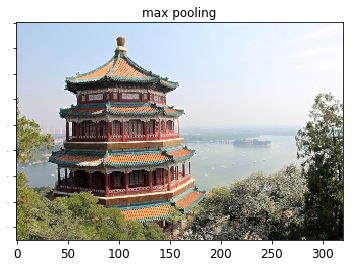

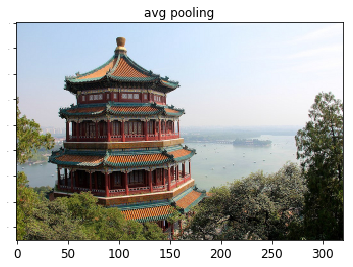

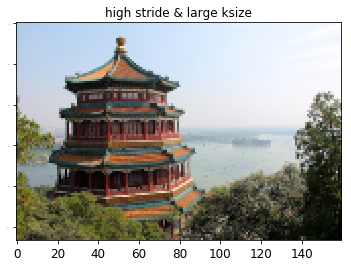

In [25]:
X = tf.placeholder(tf.float32, shape=(None, height, width, channels))
max_pool = tf.nn.max_pool(X, ksize=[1,2,2,1], strides=[1,2,2,1],padding="VALID")
avg_pool = tf.nn.avg_pool(X, ksize=[1,2,2,1], strides=[1,2,2,1],padding="VALID")
high_stride = tf.nn.avg_pool(X, ksize=[1,3,3,1], strides=[1,4,4,1],padding="VALID")

with tf.Session() as sess:
    output = sess.run(max_pool, feed_dict={X: dataset})
    output2 = sess.run(avg_pool, feed_dict={X: dataset})
    output3 = sess.run(high_stride, feed_dict={X: dataset})
    
print("Output shape: ", output.shape)
plot_image(output[0].astype(np.uint8), "max pooling")
plot_image(output2[0].astype(np.uint8), "avg pooling")
plot_image(output3[0].astype(np.uint8), "high stride & large ksize")

# CNN Architectures

Typical CNN architectures stack a few convolutional layers **(each one generally followed by a ReLU layer)**, then a pooling layer, then another few convolutional layers (+ReLU), then another pooling layer, and so on. 

**The image gets smaller and smaller as it progresses through the network, but it also typically gets deeper and deeper (i.e., with more feature maps) thanks to the convolutional layers.** 

#### At the top of the stack, a regular feedforward neural network is added, composed of a few fully connected layers (+ReLUs), and the final layer outputs the prediction (e.g., a softmax layer that outputs estimated class probabilities).

## TIP: A common mistake is to use convolution kernels (filters) that are TOO LARGE. You can often get the same effect as a 9 × 9 kernel by stacking two 3 × 3 kernels on top of each other, for a lot less compute.

![](pictures/homl_ch13_fullconvnet.jpg)

![](pictures/homl_ch13_fullconvnet2.jpg)

A good measure of this progress is machine vision is the error rate in competitions such as the ILSVRC ImageNet challenge. In this competition the top-5 error rate for image classification fell from over 26% to barely over 3% in just five years. 

## The top-five error rate is the number of test images for which the system’s top 5 predictions did not include the correct answer. 
The images are large (256 pixels high) and there are 1,000 classes, some of which are really subtle (try distinguishing 120 dog breeds). Looking at the evolution of the winning entries is a good way to understand how CNNs work.

We will first look at the classical LeNet-5 architecture (1998), then three of the winners of the ILSVRC challenge: AlexNet (2012), GoogLeNet (2014), and ResNet (2015).

# LeNet-5

Most widely used CNN architecture. 

![](pictures/homl_ch13_lenet.jpg)

There are a few extra details to be noted:
- MNIST images are 28 × 28 pixels, but they are zero-padded to 32 × 32 pixels and normalized before being fed to the network. The rest of the network does not use any padding, which is why the size keeps shrinking as the image progresses through the network.
- The average pooling layers are slightly more complex than usual: 
    - each neuron computes the mean of its inputs, **then multiplies the result by a learnable coefficient (one per map) and adds a learnable bias term (again, one per map), then finally applies the activation function.**
- Most neurons in C3 maps are connected to neurons in only three or four S2 maps (instead of all six S2 maps). See table 1 in the original paper for details.
- The output layer is a bit special: instead of computing the dot product of the inputs and the weight vector, **each neuron outputs the square of the Euclidian distance between its input vector and its weight vector.** Each output measures how much the image belongs to a particular digit class. The cross entropy cost function is now preferred, as it penalizes bad predictions much more, producing larger gradients and thus converging faster.

Yann LeCun’s website http://yann.lecun.com/ (“LENET” section) features great demos of LeNet-5 classifying digits.

# AlexNet

It is quite similar to LeNet-5, only much larger and deeper, and it was he first to stack convolutional layers directly on top of each other,
instead of stacking a pooling layer on top of each convolutional layer. 

![](pictures/homl_ch13_alexnet.jpg)

To reduce overfitting, the authors used two regularization techniques we discussed in previous chapters: 
- first they applied dropout (with a 50% dropout rate) during training to the outputs of layers F8 and F9. 
- Second, they performed data augmentation by randomly shifting the training images by various offsets, flipping them horizontally, and changing the lighting conditions.


AlexNet also uses a competitive normalization step immediately after the ReLU step of layers C1 and C3, called **local response normalization.** This form of normalization makes the neurons that most strongly activate inhibit neurons at the same location but in neighboring feature maps **(such competitive activation has been observed in biological neurons).** This encourages different feature maps to specialize, pushing them apart and forcing them to explore a wider range of features, ultimately improving generalization. Equation 13-2 shows how to apply LRN.

![](pictures/homl_ch13_alexnet2.jpg)


# GoogLe Net

GoogLeNet's great performance came in large part from the fact that the network was much deeper than previous CNNs.

**This was made possible by sub-networks called inception modules, which allow GoogLeNet to use parameters much more efficiently than previous architectures: **
## GoogLeNet actually has 10 times fewer parameters than AlexNet (roughly 6 million instead of 60 million).

- The notation “3 × 3 + 2(S)” means that the layer uses a 3 × 3 kernel, stride 2, and SAME padding. 
- The input signal is first copied and fed to four different layers. 
- All convolutional layers use the ReLU activation function. 
- **Note that the second set of convolutional layers uses different kernel sizes (1 × 1, 3 × 3, and 5 × 5), allowing them to capture patterns at different scales.**

###  Also note that every single layer uses a stride of 1 and SAME padding (even the max pooling layer), so their outputs all have the same height and width as their inputs. This makes it possible to concatenate all the outputs along the depth dimension in the final depth concat layer (i.e., stack the feature maps from all four top convolutional layers). 

This concatenation layer can be implemented in TensorFlow using the concat() operation, with axis=3 (axis 3 is the depth).

![](pictures/homl_ch13_googlenet.jpg)

You may wonder why inception modules have convolutional layers with 1 × 1 kernels. Surely these layers cannot capture any features since they look at only one pixel at a time? In fact, these layers serve two purposes:
- First, they are *configured to output many fewer feature maps than their inputs*, so they serve as bottleneck layers, meaning they **reduce dimensionality.** This is particularly useful before the 3 × 3 and 5 × 5 convolutions, since these are very computationally expensive layers.
- Second, each pair of convolutional layers ([1 × 1, 3 × 3] and [1 × 1, 5 × 5]) acts like a single, powerful convolutional layer, capable of capturing more complex patterns. Indeed, instead of sweeping a simple linear classifier across the image (as a single convolutional layer does), this pair of convolutional layers sweeps a two-layer neural network across the image.

In short, you can think of the whole inception module as a convolutional layer on steroids, able to output feature maps that capture complex patterns at various scales.

**WARNING:** The number of convolutional kernels for each convolutional layer is a hyperparameter. Unfortunately, this means that you have six more hyperparameters to tweak for every inception layer you add. 

Now let’s look at the architecture of the GoogLeNet CNN (see Figure 13-11). It is so deep that we had to represent it in three columns, but GoogLeNet is actually one tall stack, including nine inception modules (the boxes with the spinning tops) that actually contain three layers each. The number of feature maps output by each convolutional layer and each pooling layer is shown before the kernel size. The six numbers in the inception modules represent the number of feature maps output by each
convolutional layer in the module (in the same order as in Figure 13-10). Note that all the convolutional layers use the ReLU activation function.

![](pictures/homl_ch13_googlenet2.jpg)

Let’s go through this network:
- **BOXES 1-3:** The first two layers divide the image’s height and width by 4 (so its area is divided by 16), to reduce the computational load.
- **BOX 4:** Then the local response normalization layer ensures that the previous layers learn a wide variety of features (as discussed earlier).
- **BOX 6 - 7:** Two convolutional layers follow, where the first acts like a bottleneck layer. As explained earlier, you can think of this pair as a single smarter convolutional layer.
- **BOX 7:** Again, a local response normalization layer ensures that the previous layers capture a wide variety of patterns.
- **BOX 8:** Next a max pooling layer reduces the image height and width by 2, again to speed up computations.
- **BOX 9:19 (bottom of second column):** Then comes the tall stack of nine inception modules, interleaved with a couple max pooling layers to reduce dimensionality and speed up the net.
- **BOX 20:** Next, the average pooling layer uses a kernel the size of the feature maps with VALID padding, outputting 1 × 1 feature maps: this surprising strategy is called **global average pooling.** It effectively forces the previous layers to produce feature maps that are actually confidence maps for each target class (since other kinds of features would be destroyed by the averaging step). *This makes it unnecessary to have several fully connected layers at the top of the CNN (like in AlexNet), considerably reducing the number of parameters in the network and limiting the risk of overfitting.*
- **BOX 21-23:**The last layers are self-explanatory: 
    - dropout for regularization, 
    - then a fully connected layer with a softmax activation function to output estimated class probabilities.
    
**IMPORTANT NOTE:** This diagram is slightly simplified: the original GoogLeNet architecture also included two auxiliary classifiers plugged on top of the third and sixth inception modules. They were both composed of one average pooling layer, one convolutional layer, two fully connected layers, and a softmax activation layer. During training, their loss (scaled down by 70%) was added to the overall loss. The goal was to fight the vanishing gradients problem and regularize the network. However, it was shown that their effect was relatively minor.

## MORE NOTES ON INCEPTION FROM:
https://medium.com/initialized-capital/we-need-to-go-deeper-a-practical-guide-to-tensorflow-and-inception-50e66281804f

![](pictures/homl_ch13_inception.jpg)

From 10,000 feet, Inception is basically:

- An 299x299x3 input representing a visual field of 299 pixels and 3 color (RGB) channels
- Five vanilla convolution layers, with a few interspersed max-pooling operations
- Successive stacks of “Inception Modules”
- A softmax ouput layer at the end (logits) and at an intermediate output layer (aux_logits) just after the mixed 17x17x768e layer

It’s the repeated stacking of the Inception modules that makes this architecture “deep.” At first glance, this architecture doesn’t seem very complicated — after all, we’re just stacking these modules together, right? **However, this simple description belies the complexity and nuance hidden inside each Inception module.**

While stacking Inception modules leads to depth, each module is also “wide” and architected to recognize features at **multiple length scales.** In the language of convolutional neural networks, that means **introducing convolutions with several filter sizes;**
- in Inception, that means including 3x3 and 5x5 convolutions in each stacked module:

![](pictures/homl_ch13_inception2.png)

The downside, of course, is that these convolutions are expensive, especially when repeatedly stacked in a deep learning architecture! To combat this problem, Inception’s architects stacked 1x1 convolutions in front of the expensive 3x3 and 5x5 convolutions to reduce the dimensionality before each convolution:

![](pictures/homl_ch13_inception3.png)

While I won’t get into the details, the idea of using 1x1 convolutions (and factoring the 3x3 and 5x5 convolutions into smaller convolutions) to reduce the computational cost is further developed in this article https://research.google.com/pubs/pub44903.html (specifically: “Factorizing Convolutions with Large Filter Size”).

Overall, these approaches DRASTICALLY REDUCE the computational cost of Inception relative to other architectures:
### “only” 5M parameters (compared to AlexNet and VGGNet which use 12X and 36X more parameters, respectively). In turn, this reduction opens up the possibility of employing Inception on platforms with lower available resources.


# ResNets

Residual Networks or ResNets are super deep bro. The key to being able to train such deep convnets is to use **skip connections (also called shortcut connections):** 
- the signal feeding into a layer is also added to the output of a layer located a bit higher up the stack. Let’s see why this is useful.

### When training a neural network, the goal is to make it model a target function h(x). If you add the input x to the output of the network (i.e., you add a skip connection), then the network will be forced to model f(x) = h(x) – x rather than h(x). This is called residual learning.

![](pictures/homl_ch13_ResNet.jpg)

*When you initialize a regular neural network, its weights are close to zero, so the network just outputs values close to zero. If you add a skip connection, the resulting network just outputs a copy of its inputs; **in other words, it initially models the identity function.***

If the target function is fairly close to the identity function (which is often the case), this will speed up training considerably.

Moreover, if you add many skip connections, the network can start making progress even if several layers have not started learning yet. Thanks to skip connections, the signal can easily make its way across the whole network. The deep residual network can be seen as a stack of residual units, where each residual unit is a small neural network with a skip connection.

![](pictures/homl_ch13_ResNet2.jpg)

Now let’s look at ResNet’s architecture (see Figure 13-14). It is actually surprisingly simple. It starts and ends exactly like GoogLeNet (except without a dropout layer), and in between is just a very deep
stack of simple residual units. **Each residual unit is composed of two convolutional layers, with Batch Normalization (BN) and ReLU activation, using 3 × 3 kernels and preserving spatial dimensions (stride 1, SAME padding).**

![](pictures/homl_ch13_ResNet3.jpg)

Note that the number of feature maps is doubled every few residual units, at the same time as their height and width are halved (using a convolutional layer with stride 2). *When this happens the inputs cannot be added directly to the outputs of the residual unit since they don’t have the same shape (for example, this problem affects the skip connection represented by the dashed arrow in Figure 13-14).* 

**To solve this problem, the inputs are passed through a 1 × 1 convolutional layer with stride 2 and the right number of output feature maps (see Figure 13-15).**

![](pictures/homl_ch13_ResNet4.jpg)

ResNet-34 is the ResNet with 34 layers (only counting the convolutional layers and the fully connected layer) containing three residual units that output 64 feature maps, 4 RUs with 128 maps, 6 RUs with 256 maps, and 3 RUs with 512 maps.

ResNets deeper than that, such as ResNet-152, use slightly different residual units. Instead of two 3 × 3 convolutional layers with (say) 256 feature maps, they use three convolutional layers: **first a 1 × 1 convolutional layer with just 64 feature maps (4 times less), which acts a a bottleneck layer (as discussed already), then a 3 × 3 layer with 64 feature maps, and finally another 1 × 1 convolutional layer with 256 feature maps (4 times 64) that restores the original depth.**

ResNet-152 contains three such RUs that output 256 maps, then 8 RUs with 512 maps, a whopping 36 RUs with 1,024 maps, and finally 3 RUs with 2,048 maps.

**CONCLUSION:** As you can see, the field is moving rapidly, with all sorts of architectures popping out every year. One clear trend is that CNNs keep getting deeper and deeper. They are also getting lighter, requiring fewer and fewer parameters. At present, the ResNet architecture is both the most powerful and arguably the simplest, so it is really the one you should probably use for now, but keep looking at the ILSVRC challenge every year. The 2016 winners were the Trimps-Soushen team from China with an astounding 2.99% error rate. To achieve this they trained combinations of the previous models and joined them into an ensemble. Depending on the task, the reduced error rate may or may not be worth the extra complexity.


# MNIST CovNet Model

Note: instead of using the `fully_connected()`, `conv2d()` and `dropout()` functions from the `tensorflow.contrib.layers` module (as in the book), we now use the `dense()`, `conv2d()` and `dropout()` functions (respectively) from the `tf.layers` module, which did not exist when this chapter was written. **This is preferable because anything in contrib may change or be deleted without notice, while `tf.layers` is part of the official API. As you will see, the code is mostly the same.**

For all these functions:
* the `scope` parameter was renamed to `name`, and the `_fn` suffix was removed in all the parameters that had it (for example the `activation_fn` parameter was renamed to `activation`).

The other main differences in `tf.layers.dense()` are:
* the `weights` parameter was renamed to `kernel` (and the weights variable is now named `"kernel"` rather than `"weights"`),
* the default activation is `None` instead of `tf.nn.relu`

The other main differences in `tf.layers.conv2d()` are:
* the `num_outputs` parameter was renamed to `filters`,
* the `stride` parameter was renamed to `strides`,
* the default `activation` is now `None` instead of `tf.nn.relu`.

The other main differences in `tf.layers.dropout()` are:
* it takes the dropout rate (`rate`) rather than the keep probability (`keep_prob`). Of course, `rate == 1 - keep_prob`,
* the `is_training` parameters was renamed to `training`.

# NOTE: Peep the documentation for tf.layers.conv2d, its super helpful!!!

Signature: tf.layers.conv2d(inputs, filters, kernel_size, strides=(1, 1), padding='valid', data_format='channels_last', dilation_rate=(1, 1), activation=None, use_bias=True, kernel_initializer=None, bias_initializer=<tensorflow.python.ops.init_ops.Zeros object at 0x000001CC800DDDA0>, kernel_regularizer=None, bias_regularizer=None, activity_regularizer=None, trainable=True, name=None, reuse=None)

...

This layer creates a convolution kernel that is convolved (actually cross-correlated) with the layer input to produce a tensor of outputs. If `use_bias` is True (and a `bias_initializer` is provided), **a bias vector is created and added to the outputs.** Finally, if`activation` is not `None`, it is applied to the outputs as well.

Arguments:
- **inputs:** Tensor input.
- **filters:** Integer, the dimensionality of the output space (i.e. the number of filters in the convolution).
- **kernel_size:** An integer or tuple/list of 2 integers, specifying the width and height of the 2D convolution window. **Can be a single integer to specify the same value for all spatial dimensions.**
- **strides:** An integer or tuple/list of 2 integers, specifying the strides of the convolution along the height and width. **Can be a single integer to specify the same value for all spatial dimensions.** Specifying any stride value != 1 is incompatible with specifying any `dilation_rate` value != 1.
- **padding:** One of `"valid"` or `"same"` (case-insensitive).
- **data_format:** A string, one of `channels_last` (default) or `channels_first`. The ordering of the dimensions in the inputs. `channels_last` corresponds to inputs with shape `(batch, height, width, channels)` while `channels_first` corresponds to inputs with shape `(batch, channels, height, width)`. **THIS ADDRESES OUR EARLIER CONFUSION**
- dilation_rate: An integer or tuple/list of 2 integers, specifying the dilation rate to use for dilated convolution. Can be a single integer to specify the same value for all spatial dimensions. Currently, specifying any `dilation_rate` value != 1 is incompatible with specifying any stride value != 1.
- **activation:** Activation function. Set it to None to maintain a linear activation.
- **use_bias:** Boolean, whether the layer uses a bias.
- **kernel_initializer:** An initializer for the convolution kernel.
- **bias_initializer:** An initializer for the bias vector. If None, no bias will be applied.
- **kernel_regularizer:** Optional regularizer for the convolution kernel.
- **bias_regularizer:** Optional regularizer for the bias vector.
- **activity_regularizer:** Regularizer function for the output.
- **trainable:** Boolean, **if `True` also add variables to the graph collection `GraphKeys.TRAINABLE_VARIABLES` (see `tf.Variable`).**
- **name:** A string, the name of the layer.
- **reuse:** Boolean, whether to reuse the weights of a previous layer by the same name.

In [39]:
# set params
height = 28
width = 28
channels = 1
n_inputs = height * width

conv1_fmaps = 32
conv1_ksize = 3
conv1_stride = 1
conv1_pad = "SAME"

conv2_fmaps = 64
conv2_ksize = 3
conv2_stride = 2
conv2_pad = "SAME"

pool3_fmaps = conv2_fmaps

n_fc1 = 64
n_outputs = 10

In [44]:
# build graph
reset_graph()

with tf.name_scope("inputs"):
    X = tf.placeholder(tf.float32, shape=[None, n_inputs], name="X")
    X_reshaped = tf.reshape(X, shape=[-1, height, width, channels])
    y = tf.placeholder(tf.int32, shape=[None], name="y")

conv1 = tf.layers.conv2d(X_reshaped, filters=conv1_fmaps, kernel_size=conv1_ksize,
                         strides=conv1_stride, padding=conv1_pad,
                         activation=tf.nn.relu, name="conv1")

conv2 = tf.layers.conv2d(conv1, filters=conv2_fmaps, kernel_size=conv2_ksize,
                         strides=conv2_stride, padding=conv2_pad,
                         activation=tf.nn.relu, name="conv2")

with tf.name_scope("pool3"):
    pool3 = tf.nn.max_pool(conv2, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding="VALID")
    pool3_flat = tf.reshape(pool3, shape=[-1, pool3_fmaps * 7 * 7])

with tf.name_scope("fc1"):
    fc1 = tf.layers.dense(pool3_flat, n_fc1, activation=tf.nn.relu, name="fc1")

with tf.name_scope("output"):
    logits = tf.layers.dense(fc1, n_outputs, name="output")
    Y_proba = tf.nn.softmax(logits, name="Y_proba")

with tf.name_scope("train"):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(logits=logits, labels=y)
    loss = tf.reduce_mean(xentropy)
    optimizer = tf.train.AdamOptimizer()
    training_op = optimizer.minimize(loss)

with tf.name_scope("eval"):
    correct = tf.nn.in_top_k(logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))

with tf.name_scope("init_and_save"):
    init = tf.global_variables_initializer()
    saver = tf.train.Saver()

In [42]:
# import data
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("/tmp/data/")

Extracting /tmp/data/train-images-idx3-ubyte.gz
Extracting /tmp/data/train-labels-idx1-ubyte.gz
Extracting /tmp/data/t10k-images-idx3-ubyte.gz
Extracting /tmp/data/t10k-labels-idx1-ubyte.gz


In [46]:
# train model
n_epochs = 10
batch_size = 10 # make this 100 when using GPU... 100 is too large for this comp tho

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        for iteration in range(mnist.train.num_examples // batch_size):
            X_batch, y_batch = mnist.train.next_batch(batch_size)
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        acc_train = accuracy.eval(feed_dict={X: X_batch, y: y_batch})
        acc_test = accuracy.eval(feed_dict={X: mnist.test.images, y: mnist.test.labels})
        print(epoch, "Train accuracy:", acc_train, "Test accuracy:", acc_test)

        save_path = saver.save(sess, "./my_mnist_model")

0 Train accuracy: 1.0 Test accuracy: 0.9836
1 Train accuracy: 1.0 Test accuracy: 0.9851
2 Train accuracy: 1.0 Test accuracy: 0.9889
3 Train accuracy: 1.0 Test accuracy: 0.9861
4 Train accuracy: 1.0 Test accuracy: 0.988
5 Train accuracy: 1.0 Test accuracy: 0.9884
6 Train accuracy: 1.0 Test accuracy: 0.9862
7 Train accuracy: 1.0 Test accuracy: 0.9904
8 Train accuracy: 1.0 Test accuracy: 0.9883
9 Train accuracy: 1.0 Test accuracy: 0.9874


# Exercises:
### 1. What are the advantages of a CNN over a fully connected DNN for image classification?

Below are the main advanges of a CNN over a traditional fully connected DNN for image classification:
- Because consecutive layers are only partially connected and because it heavily reuses its weights, **a CNN has many fewer parameters than a fully connected DNN**, which makes it much faster to train, reduces probability of overfitting, and requires much less training data.
- When a CNN has learned a kernel that can detect a particular feature, **it can detect that feature anywhere on the image.** In contrast, when a DNN learns a feature in one location, it can detect it ONLY IN THAT PARTICULAR LOCATION... Since images typically have very repetitive features, CNNs are able to generalist much better than DNNs for image processing tasks using FEWER training examples. 
- DNNs had NO prior knowledge of how pixels are organized, so it does not know that nearby pixels are close. CNNs architecture  on the other hand **embeds this prior knowledge. Lower layers typically identify features in small areas of the images, while higher layers combine the lower level features into larger features... ** This works well with most natural images.

### 2. Consider a CNN composed of three convolutional layers, each with 3 × 3 kernels, a stride of 2, and SAME padding. The lowest layer outputs 100 feature maps, the middle one outputs 200, and the top one outputs 400. The input images are RGB images of 200 × 300 pixels. What is the total number of parameters in the CNN? If we are using 32-bit floats, at least how much RAM will this network require when making a prediction for a single instance? What about when training on a mini-batch of 50 images?

### Parameters:

**1. First conv layer**
- 3 X 3 kernels, and input has 3 chanels... 
- each feature map has 3x3x3 weights, plus a bias term, thats 27+1 = **28 parameters per feature map.** THIS WILL NOT CHANGE NO MATTER WHAT THE STRIDE VALUE.
- with 100 feature maps, it will have 100 kernels, thats 28x100 = **2800 parameters in the layer**
 
**2. Second conv layer**
- 3x3 kernels, thats **9 params per feature map**
- 100 feature map inputs
- 200 feature map outputs
- (9 x 100 + bias) x 200 = **180,200 params in the layer**

**3. Third conv layer**
- 3x3 kernels, thats **9 params per feature map**
- 200 feature map inputs
- 200 feature map outputs
- (9 x 200 + bias) x 400 = **720,400 params in the layer**

**Total params = 2800 + 180200 + 720400 = 903,400 **

### RAM:

**1. First conv layer**
- First we computer the feature map size for each layer.
- 2 SAME padding, horizontal and vertical size of feature maps are divided by 2 at each layer (rounding up if necessary because of SAME), so as the input channels are 200 x 300 pixels:
    - the first layers feature maps will be 100 x 150
    - second layer feature maps 50 x 70
    - third layer feature maps 25 x 38. 
- Since 32 bits is 4 bytes (HMMM THATS NEWS TO MEEE!!!!):
    - the first layer takes up 4x100x150x 100 feat maps = 6 million bytes (about 5.7 MB, considering that 1 MB = 1,024 KB and 1 KB = 1,024 bytes)
    - second layer: 4 x 50 x 75 x 200 = 3 million bytes (about 2.9 MB)
    - third layer: 4 x 25 x 38 x 400 = 1.52 million bytes (about 2.9 MB)

- However, once a layer has been computed, the memory occupied by the previous layer can be released, so if everything is well optimized, only 6 + 9 = 15 million bytes (about 14.3 MB) of RAM will be required (when the second layer has just been computed, but the memory occupied by the first layer is not released yet). 

But wait, you also need to add the memory occupied by the CNN’s parameters. We computed earlier that it has 903,400 parameters, each using up 4 bytes, so this adds 3,613,600 bytes (about 3.4 MB). The total
RAM required is (at least) 18,613,600 bytes (about 17.8 MB). Lastly, let’s compute the minimum amount of RAM required when training the CNN on a mini-batch of 50 images. 
- During training TensorFlow uses backpropagation, which requires keeping all values computed during the forward pass until the reverse pass begins. So we must compute the total RAM required by all layers for a single instance and multiply that by 50! 
- At that point let’s start counting in megabytes rather than bytes. We computed before that the three layers require respectively 5.7, 2.9, and 1.4 MB for each instance. That’s a total of 10.0 MB per instance. So for 50 instances the total RAM is 500 MB. 
- Add to that the RAM required by the input images, which is 50 × 4 × 200 × 300 × 3 = 36 million bytes (about 34.3 MB), plus the RAM required for the model parameters, which is about 3.4 MB (computed earlier), plus some RAM for the gradients (we will neglect them since they can be released gradually as backpropagation goes down the layers during the reverse pass). 

**We are up to a total of roughly 500.0 + 34.3 + 3.4 = 537.7 MB. And that’s really an optimistic bare minimum.**

### 3. If your GPU runs out of memory while training a CNN, what are five things you could try to solve the problem?

If your GPU runs our of memory whilst training a CNN, here are five things you could try to solve the problem (other than purchasing a GPU with more RAM obvi....):
- Reduce the mini-batch size
- Reduce the dimensionality using a larger stride in one or more layers
- Remove one or more layers
- Use 16-bit floats instead of 32-bit floats
- Distribute the CNN across multiple devices

### 4. Why would you want to add a max pooling layer rather than a convolutional layer with the same stride?
- A max pooling layer has NO parameters... ie its just taking the max of the receptive area. **However a convolutional layer even with a high stride has a shit ton of parameters that will need to get trained!!!**

### 5. When would you want to add a local response normalization layer?
- A local response normalization layer makes the neurons that most strongly activate inhibit neorns at the same location but in neighboring geature maps, which encourages different feature maps to specialize and pushes them apart, forcing them to explore a wider range of features.
- It is typically used in the lower layers to have a larger pool of low-level feature that the upper layer can build upon.

### 6. Can you name the main innovations in AlexNet, compared to LeNet-5? What about the main innovations in GoogLeNet and ResNet?
The main innovations in AlexNet compared to LeNet-5 are:
 - (1) it is much larger and deeper, and 
 - (2) it stacks convolutional layers directly on top of each other, instead of stacking a pooling layer on top of each convolutional layer. 
 
The main innovation in GoogLeNet is:
- the introduction of inception modules, which make it possible to have a much deeper net than previous CNN architectures, with fewer parameters. 

ResNet’s main innovation is:
- the introduction of skip connections, which make it possible to go well beyond 100 layers. Arguably, its simplicity and consistency are also rather innovative.
